In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install Dependencies (安裝依賴套件)

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 15647 (delta 130), reused 173 (delta 98), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.65 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (10658/10658), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
Setup complete. Using torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset (下載格式正確的自定義數據集)
如果有換測試集，請務必更換此處程式碼。

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="fJNx9oJEEE4o6DYMMfYC", model_format="yolov5", notebook="roboflow-yolov5")
#The best practice is to put the dataset one directory above the YOLOv5 repo
##打開Roboflow裡設定好的數據集，點擊Export Dataset，貼上Terminal的網址，請注意curl前面必須有驚嘆號，不然會報錯哦!
%cd /content/yolov5
!curl -L "https://app.roboflow.com/ds/thXOYpBFvW?key=8UFWK2DTSt" &gt; roboflow.zip; unzip roboflow.zip; rm roboflow.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.9 MB/s eta 0:00:00
/content/yolov5
/bin/bash: gt: command not found
/bin/bash: roboflow.zip: command not found
unzip:  cannot find or open roboflow.zip, roboflow.zip.zip or roboflow.zip.ZIP.
rm: cannot remove 'roboflow.zip': No such file or directory


In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
##這邊是貼上Jupyter方式的程式碼，直接複製貼上就可以，有黑色方塊不用管，貼上會自己出現。
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="fJNx9oJEEE4o6DYMMfYC")
project = rf.workspace("project-c6c5q").project("baseballplayer-eni5v")
dataset = project.version(1).download("yolov5")

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to baseballplayer-1 in yolov5pytorch:: 100%|██████████| 518/518 [00:00<00:00, 2160.32it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- baseball1
nc: 1
roboflow:
  license: CC BY 4.0
  project: baseballplayer-eni5v
  url: https://universe.roboflow.com/project-c6c5q/baseballplayer-eni5v/dataset/1
  version: 1
  workspace: project-c6c5q
test: ../test/images
train: baseballplayer-1/train/images
val: baseballplayer-1/valid/images


#Run Inference  With Trained Weights (用訓練過的權重進行測試)
##*請務必確認，已經在yolov5資料夾底下上傳best.pt成功，並確認測試集為正確路徑，再點擊下方執行。
此部分可以調測試信心指數，測試速度在輸出結果最下方有寫。

Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/best.pt --img 416 --conf 0.45 --source /content/yolov5/baseballplayer-1/test/images

/content/yolov5
detect: weights=['/content/yolov5/best.pt'], source=/content/yolov5/baseballplayer-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.45, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5x summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/10 /content/yolov5/baseballplayer-1/test/images/0002_jpg.rf.1c2c81ef3c07719a487cce05bb34a1f7.jpg: 416x416 1 baseball1, Done. (0.008s)
image 2/10 /content/yolov5/baseballplayer-1/test/images/0014_jpg.rf.c0caf0c4bacd4e785be48e56af1ee707.jpg: 416x416 1 baseball1, Done. (0.008s)
image 3/10 /content/yolov5/baseba

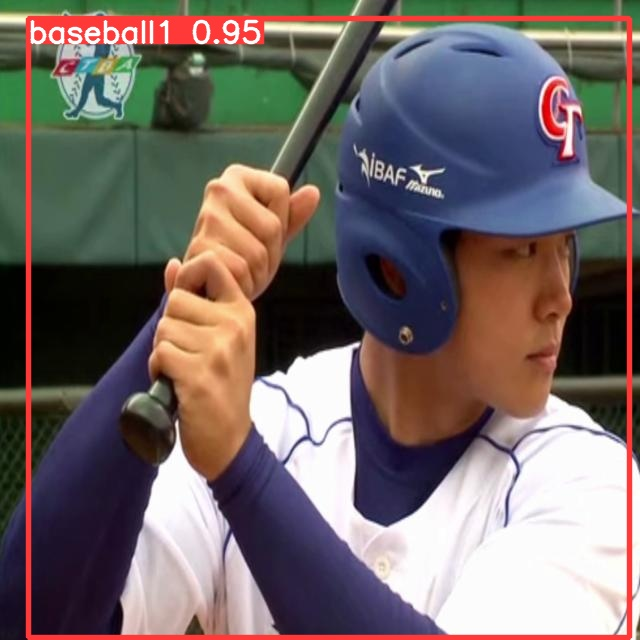

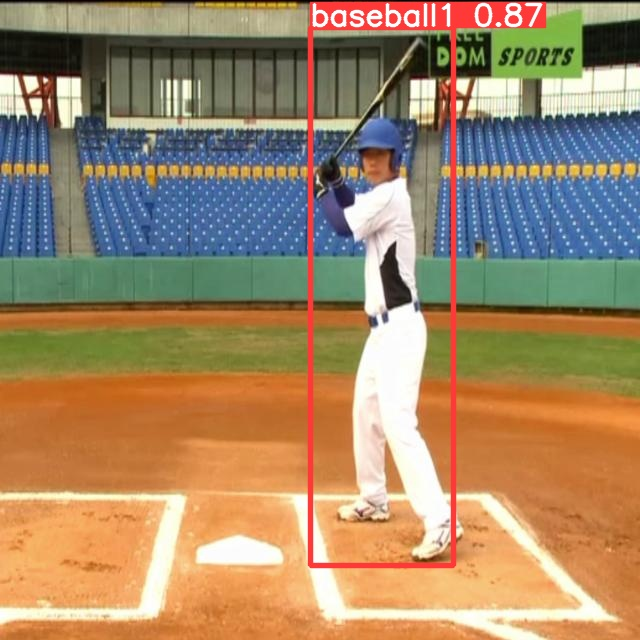

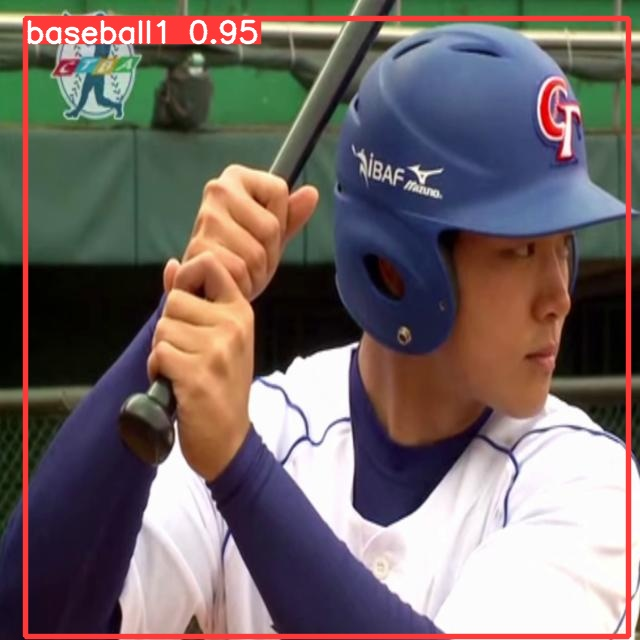

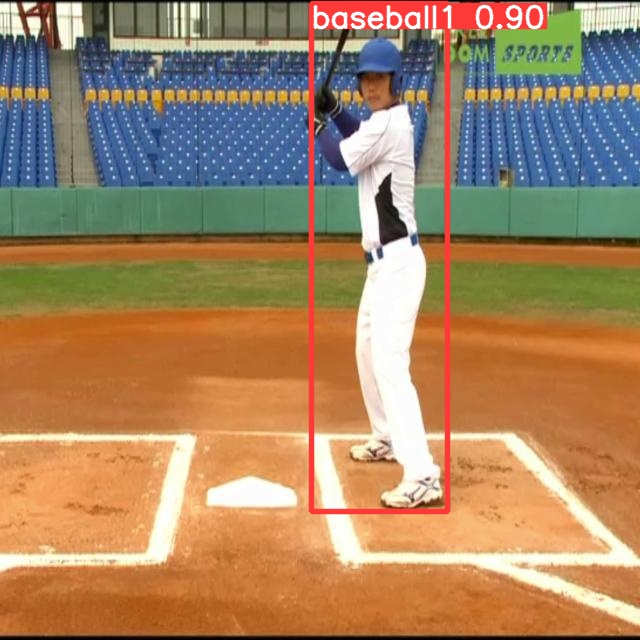

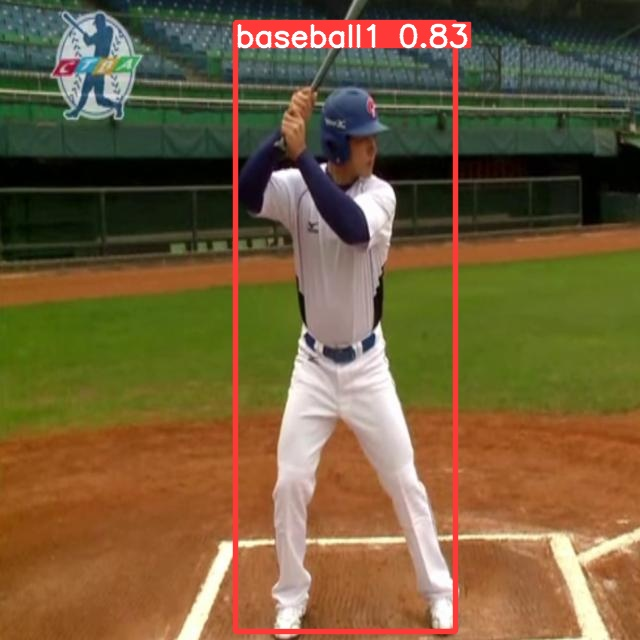

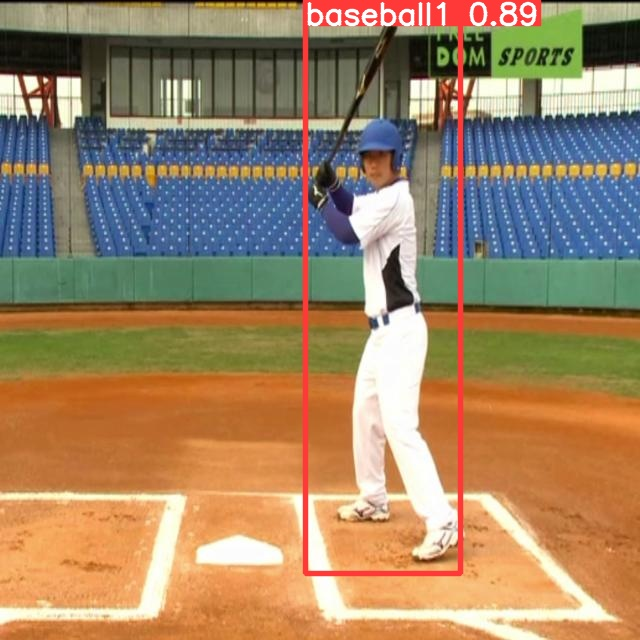

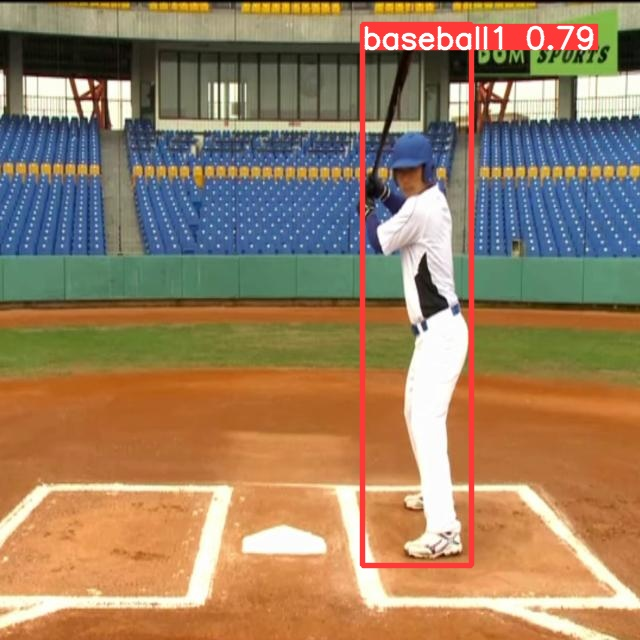

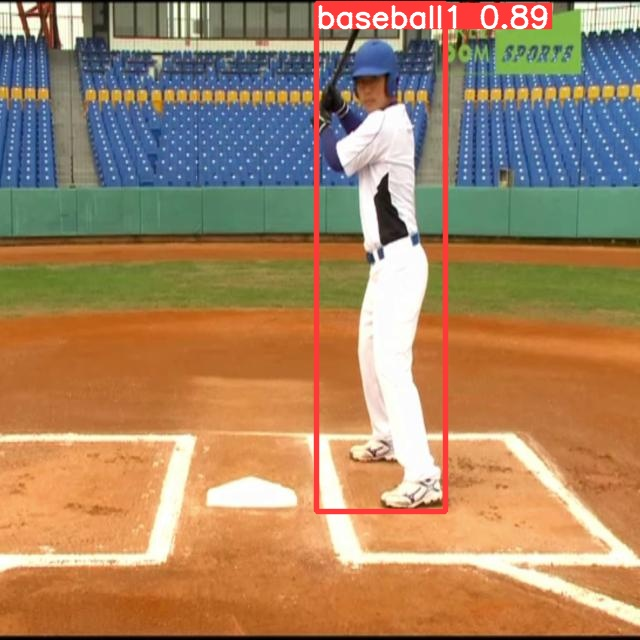

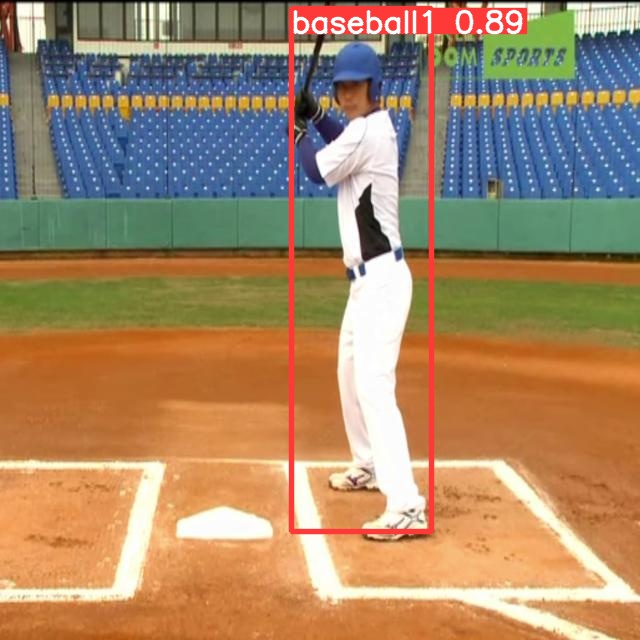

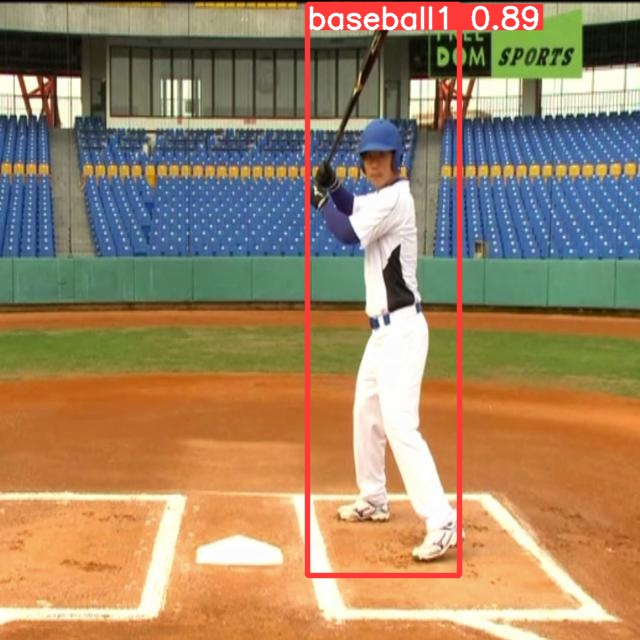

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference (輸出測試結果)

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#下載測試資料夾
!cp -r /content/yolov5/runs/detect/exp /content/drive/MyDrive/